In [1]:
import numpy as np # linear 
from numpy import concatenate
from math import sqrt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
from pandas import concat
from datetime import datetime
import matplotlib.pyplot as pyplot
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

## Glimpse Data

Read data

In [2]:
btc = pd.read_csv('/data/training.csv')
btc.set_index('Timestamp')

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,TDA
Timestamp,,,,,,,,
2017-01-03 04:00:00,1023.315250,1023.436750,1023.267500,1023.392250,2.499811,2557.745244,1023.345857,1.512730
2017-01-03 05:00:00,1022.452955,1022.454318,1022.223636,1022.261591,5.433221,5556.951296,1022.299328,1.521520
2017-01-03 06:00:00,1017.268864,1017.485000,1016.845000,1017.320909,6.754669,6875.645449,1017.148655,0.889232
2017-01-03 07:00:00,1012.305532,1012.549574,1012.033617,1012.318936,3.272033,3311.363934,1012.258033,1.018090
2017-01-03 08:00:00,1014.850638,1015.312128,1014.587660,1015.101064,3.856818,3917.441456,1014.977552,1.017370
...,...,...,...,...,...,...,...,...
2020-12-30 20:00:00,28804.122167,28826.711333,28777.034000,28805.678000,12.649963,364479.654389,28801.783950,3884.190000
2020-12-30 21:00:00,28840.522833,28862.506833,28812.956333,28843.839833,7.912897,227921.940911,28837.869651,4046.840000
2020-12-30 22:00:00,28820.040500,28837.640500,28795.527000,28816.996833,3.954189,113881.747431,28816.717681,2762.500000


Select an eventful time period in Bitcoin history

In [3]:
# Select the years 2017 on
btc = btc.loc['2010':]

#### Time resampling

In [4]:
btc.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,TDA
20100,2019-04-20 16:00:00,5324.226897,5325.084310,5323.238276,5324.239310,0.958748,5106.092381,5324.267107,21.7167
20101,2019-04-20 17:00:00,5315.988966,5317.052414,5314.585345,5315.913793,4.065730,21606.853254,5315.689465,20.8140
20102,2019-04-20 18:00:00,5311.773455,5312.570727,5311.106364,5311.963091,1.066115,5662.866689,5311.725131,13.2219
20103,2019-04-20 19:00:00,5318.488542,5319.456875,5318.088542,5319.093542,1.200785,6387.066892,5318.750702,13.8803
20104,2019-04-20 20:00:00,5322.951500,5324.086000,5321.700000,5322.936333,1.830436,9734.838371,5322.753415,11.3486


#### Plot time series

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

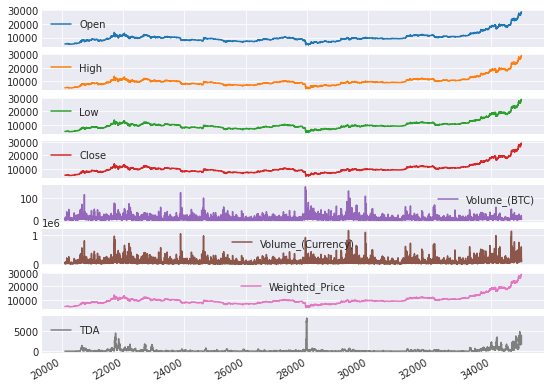

In [5]:
btc.plot(figsize=(9,7), subplots=True)

#### Keras Long Short-Term Memory (LSTM) Model

In [66]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    print(data)
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [171]:
# load dataset
values = btc.drop(columns=['Timestamp', 'Volume_(Currency)', 'Weighted_Price', 'TDA']).values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

[[0.03154869 0.03112358 0.03329152 0.03180531 0.00632798]
 [0.03121019 0.03079389 0.03293662 0.03146381 0.02721717]
 [0.03103698 0.03060992 0.03279393 0.03130176 0.00704984]
 ...
 [0.99699346 0.9962708  0.99599359 0.99542679 0.02646724]
 [0.99659265 0.99595899 0.99590348 0.99511055 0.01584663]
 [1.         1.         1.         1.         0.03859266]]


In [172]:
ncols = reframed.shape[1]

In [173]:
print(reframed)
print(ncols)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  \
1       0.031549   0.031124   0.033292   0.031805   0.006328  0.031210   
2       0.031210   0.030794   0.032937   0.031464   0.027217  0.031037   
3       0.031037   0.030610   0.032794   0.031302   0.007050  0.031313   
4       0.031313   0.030893   0.033080   0.031594   0.007955  0.031496   
5       0.031496   0.031083   0.033228   0.031752   0.012189  0.030502   
...          ...        ...        ...        ...        ...       ...   
14884   0.994296   0.994216   0.992682   0.993102   0.135813  0.996339   
14885   0.996339   0.995822   0.995235   0.994963   0.084932  0.997835   
14886   0.997835   0.997292   0.996708   0.996528   0.053083  0.996993   
14887   0.996993   0.996271   0.995994   0.995427   0.026467  0.996593   
14888   0.996593   0.995959   0.995903   0.995111   0.015847  1.000000   

        var2(t)   var3(t)   var4(t)   var5(t)  
1      0.030794  0.032937  0.031464  0.027217  
2      0.030610

In [174]:

reframed.drop(reframed.columns[[ncols-1,ncols-3,ncols-4,ncols-5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var4(t)
1   0.031549   0.031124   0.033292   0.031805   0.006328  0.031464
2   0.031210   0.030794   0.032937   0.031464   0.027217  0.031302
3   0.031037   0.030610   0.032794   0.031302   0.007050  0.031594
4   0.031313   0.030893   0.033080   0.031594   0.007955  0.031752
5   0.031496   0.031083   0.033228   0.031752   0.012189  0.030780


In [175]:
# split into train and test sets
values = reframed.values
n_test_hours = 90 * 24
n_train_hours = values.shape[0] - n_test_hours
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12728, 1, 5) (12728,) (2160, 1, 5) (2160,)


In [177]:

# design network
#model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

regressor = Sequential()

regressor.add(LSTM(units = 20, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = regressor.fit(train_X, train_y, epochs = 7, batch_size = 32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/7
398/398 - 1s - loss: 0.0013 - val_loss: 0.0240
Epoch 2/7
398/398 - 1s - loss: 9.1933e-04 - val_loss: 0.0083
Epoch 3/7
398/398 - 1s - loss: 5.3737e-04 - val_loss: 0.0024
Epoch 4/7
398/398 - 1s - loss: 3.5924e-04 - val_loss: 1.8727e-04
Epoch 5/7
398/398 - 1s - loss: 2.4371e-04 - val_loss: 8.4683e-05
Epoch 6/7
398/398 - 1s - loss: 1.8229e-04 - val_loss: 7.5599e-05
Epoch 7/7
398/398 - 1s - loss: 1.4426e-04 - val_loss: 2.4124e-04


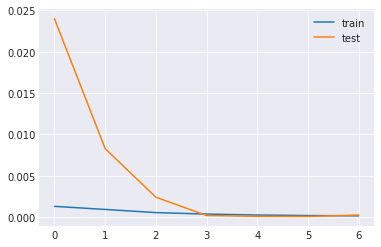

In [178]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [179]:
print(test_X.shape)
print(train_X.shape)

(2160, 1, 5)
(12728, 1, 5)


In [180]:
yhat = regressor.predict(test_X)
print(test_X.shape, yhat.shape)

(2160, 1, 5) (2160, 1, 1)


In [181]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))
test_y = np.transpose(test_y)

In [182]:
print(yhat.shape)
print(test_y.shape)
print(yhat)
print(test_y)

(2160, 1)
(2160,)
[[0.24776354]
 [0.24781221]
 [0.24779476]
 ...
 [1.0515747 ]
 [1.0491302 ]
 [1.0482522 ]]
[0.24831803 0.24829172 0.24885042 ... 0.99542679 0.99511055 1.        ]


In [183]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[[0.24776354 0.24786858 0.24964403 0.2482426  0.03262661]
 [0.24781221 0.24781949 0.24974127 0.24831803 0.00881971]
 [0.24779476 0.24781478 0.24970939 0.24829172 0.01230666]
 ...
 [1.05157471 0.99729151 0.99670844 0.99652784 0.05308284]
 [1.0491302  0.9962708  0.99599359 0.99542679 0.02646724]
 [1.04825222 0.99595899 0.99590348 0.99511055 0.01584663]]
Test RMSE: 377.996
